## Project: Orange juice brand prediction using machine learning
- **Source**: Stine, Robert A., Foster, Dean P., Waterman, Richard P. Business Analysis Using Regression (1998). Published by Springer.  
- **Author**: Santiago Trejo  
- **Date**: 26 / 09 / 2025

In [25]:
#Step 0 Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder
    )
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
    )
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score,
    r2_score, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay
    )
from sklearn.inspection import permutation_importance

### 1. **Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [3]:
#Step 1 Load Data
url = 'https://raw.githubusercontent.com/selva86/' + \
'datasets/master/orange_juice_withmissing.csv'
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase        1070 non-null   object 
 1   WeekofPurchase  1070 non-null   int64  
 2   StoreID         1069 non-null   float64
 3   PriceCH         1069 non-null   float64
 4   PriceMM         1066 non-null   float64
 5   DiscCH          1068 non-null   float64
 6   DiscMM          1066 non-null   float64
 7   SpecialCH       1068 non-null   float64
 8   SpecialMM       1065 non-null   float64
 9   LoyalCH         1065 non-null   float64
 10  SalePriceMM     1065 non-null   float64
 11  SalePriceCH     1069 non-null   float64
 12  PriceDiff       1069 non-null   float64
 13  Store7          1070 non-null   object 
 14  PctDiscMM       1065 non-null   float64
 15  PctDiscCH       1068 non-null   float64
 16  ListPriceDiff   1070 non-null   float64
 17  STORE           1068 non-null   f

In [4]:
df_raw.sample(10, random_state=2025)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
282,MM,247,3.0,1.99,2.23,0.0,0.0,0.0,0.0,0.003689,2.23,1.99,0.24,No,0.000000,0.0,0.24,3.0
786,MM,234,3.0,1.79,2.09,0.0,0.0,0.0,0.0,0.067109,2.09,1.79,0.30,No,0.000000,0.0,0.30,3.0
826,CH,244,4.0,1.99,2.23,0.0,0.0,0.0,0.0,0.914906,2.23,1.99,0.24,No,0.000000,0.0,0.24,4.0
465,CH,267,7.0,1.86,2.13,0.0,0.0,1.0,0.0,0.787008,2.13,1.86,0.27,Yes,0.000000,0.0,0.27,0.0
256,CH,232,7.0,1.69,1.99,0.0,0.4,1.0,1.0,0.331072,1.59,1.69,-0.10,Yes,0.201005,0.0,0.30,0.0
412,MM,234,7.0,1.75,1.99,0.0,0.4,1.0,0.0,0.227109,1.59,1.75,-0.16,Yes,0.201005,0.0,0.24,0.0
14,CH,278,7.0,2.06,2.13,0.0,0.0,0.0,0.0,0.744000,2.13,2.06,0.07,Yes,0.000000,0.0,0.07,0.0
754,MM,241,1.0,1.86,1.99,0.0,0.3,0.0,1.0,0.364800,1.69,1.86,-0.17,No,0.150754,0.0,0.13,1.0
273,MM,229,3.0,1.79,1.79,0.0,0.0,0.0,0.0,0.027488,1.79,1.79,0.00,No,0.000000,0.0,0.00,3.0
294,MM,275,2.0,1.96,NaN,0.0,0.8,0.0,1.0,0.000254,1.38,1.96,-0.58,No,0.366972,0.0,0.22,2.0


### 2. **Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [5]:
#Step 2 Preprocessing
df_juice_baking = df_raw.copy()
df_juice_baking = df_juice_baking.drop(columns=['STORE','Store7','SalePriceMM','SalePriceCH','ListPriceDiff','PctDiscCH','PctDiscMM'])
df_juice_baking.columns = df_juice_baking.columns.str.lower()
columns_cat = ['purchase','storeid','specialch','specialmm']
df_juice_baking[columns_cat] = df_juice_baking[columns_cat].astype('category')
df_juice_baking = df_juice_baking.dropna()
df_juice_baking['storeid'] = df_juice_baking['storeid'].apply(lambda x: "store_"+str(int(x))) #store_1
df_juice_baking['specialch'] = df_juice_baking['specialch'].apply(lambda x: "sp_"+str(int(x)))
df_juice_baking['specialmm'] = df_juice_baking['specialmm'].apply(lambda x: "sp_"+str(int(x)))
df = df_juice_baking.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   purchase        1046 non-null   category
 1   weekofpurchase  1046 non-null   int64   
 2   storeid         1046 non-null   category
 3   pricech         1046 non-null   float64 
 4   pricemm         1046 non-null   float64 
 5   discch          1046 non-null   float64 
 6   discmm          1046 non-null   float64 
 7   specialch       1046 non-null   category
 8   specialmm       1046 non-null   category
 9   loyalch         1046 non-null   float64 
 10  pricediff       1046 non-null   float64 
dtypes: category(4), float64(6), int64(1)
memory usage: 70.0 KB


### 3. **Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [7]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2025, stratify=df['purchase'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=2025, stratify=df_train['purchase'])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((846, 11), (95, 11), (105, 11))

In [9]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
weekofpurchase,846.0,253.836879,15.685726,227.000000,239.000000,256.00,267.000000,278.000000
pricech,846.0,1.865000,0.103447,1.690000,1.790000,1.86,1.990000,2.090000
pricemm,846.0,2.080733,0.136593,1.690000,1.990000,2.09,2.180000,2.290000
discch,846.0,0.049941,0.115513,0.000000,0.000000,0.00,0.000000,0.500000
discmm,846.0,0.122931,0.211555,0.000000,0.000000,0.00,0.240000,0.800000
loyalch,846.0,0.568539,0.307563,0.000011,0.331072,0.60,0.855005,0.999934
pricediff,846.0,0.142742,0.269252,-0.670000,0.000000,0.23,0.320000,0.640000


,count,unique,top,freq
purchase,846,2,CH,519
storeid,846,5,store_7,288
specialch,846,2,sp_0,726
specialmm,846,2,sp_0,702


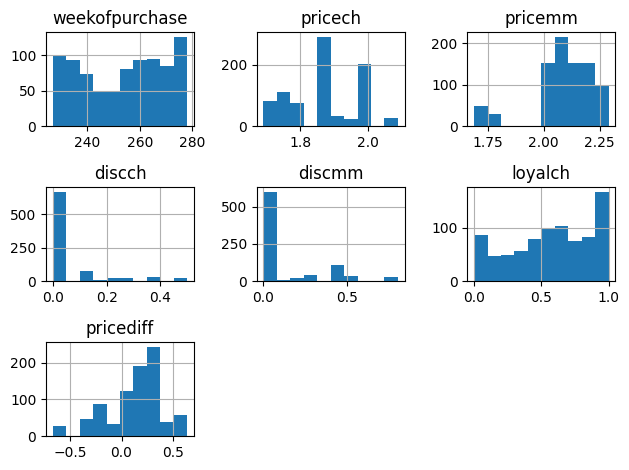

In [10]:
df_train.hist()
plt.tight_layout()
plt.show()

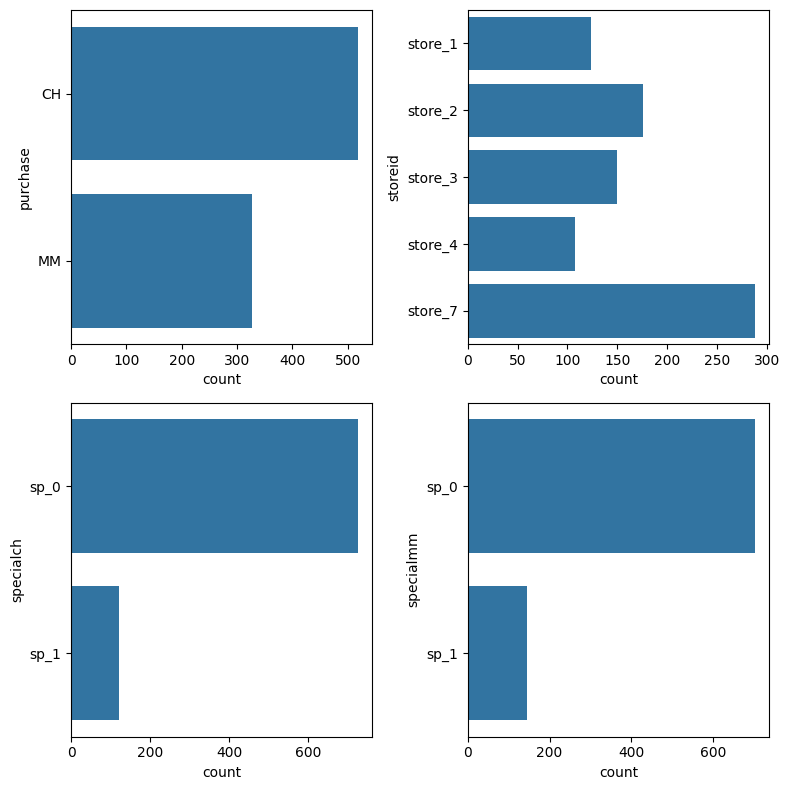

In [13]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
sns.countplot(df_train, y='purchase', ax=ax[0,0])
sns.countplot(df_train, y='storeid', ax=ax[0,1])
sns.countplot(df_train, y='specialch', ax=ax[1,0])
sns.countplot(df_train, y='specialmm', ax=ax[1,1])
plt.tight_layout()
plt.show()

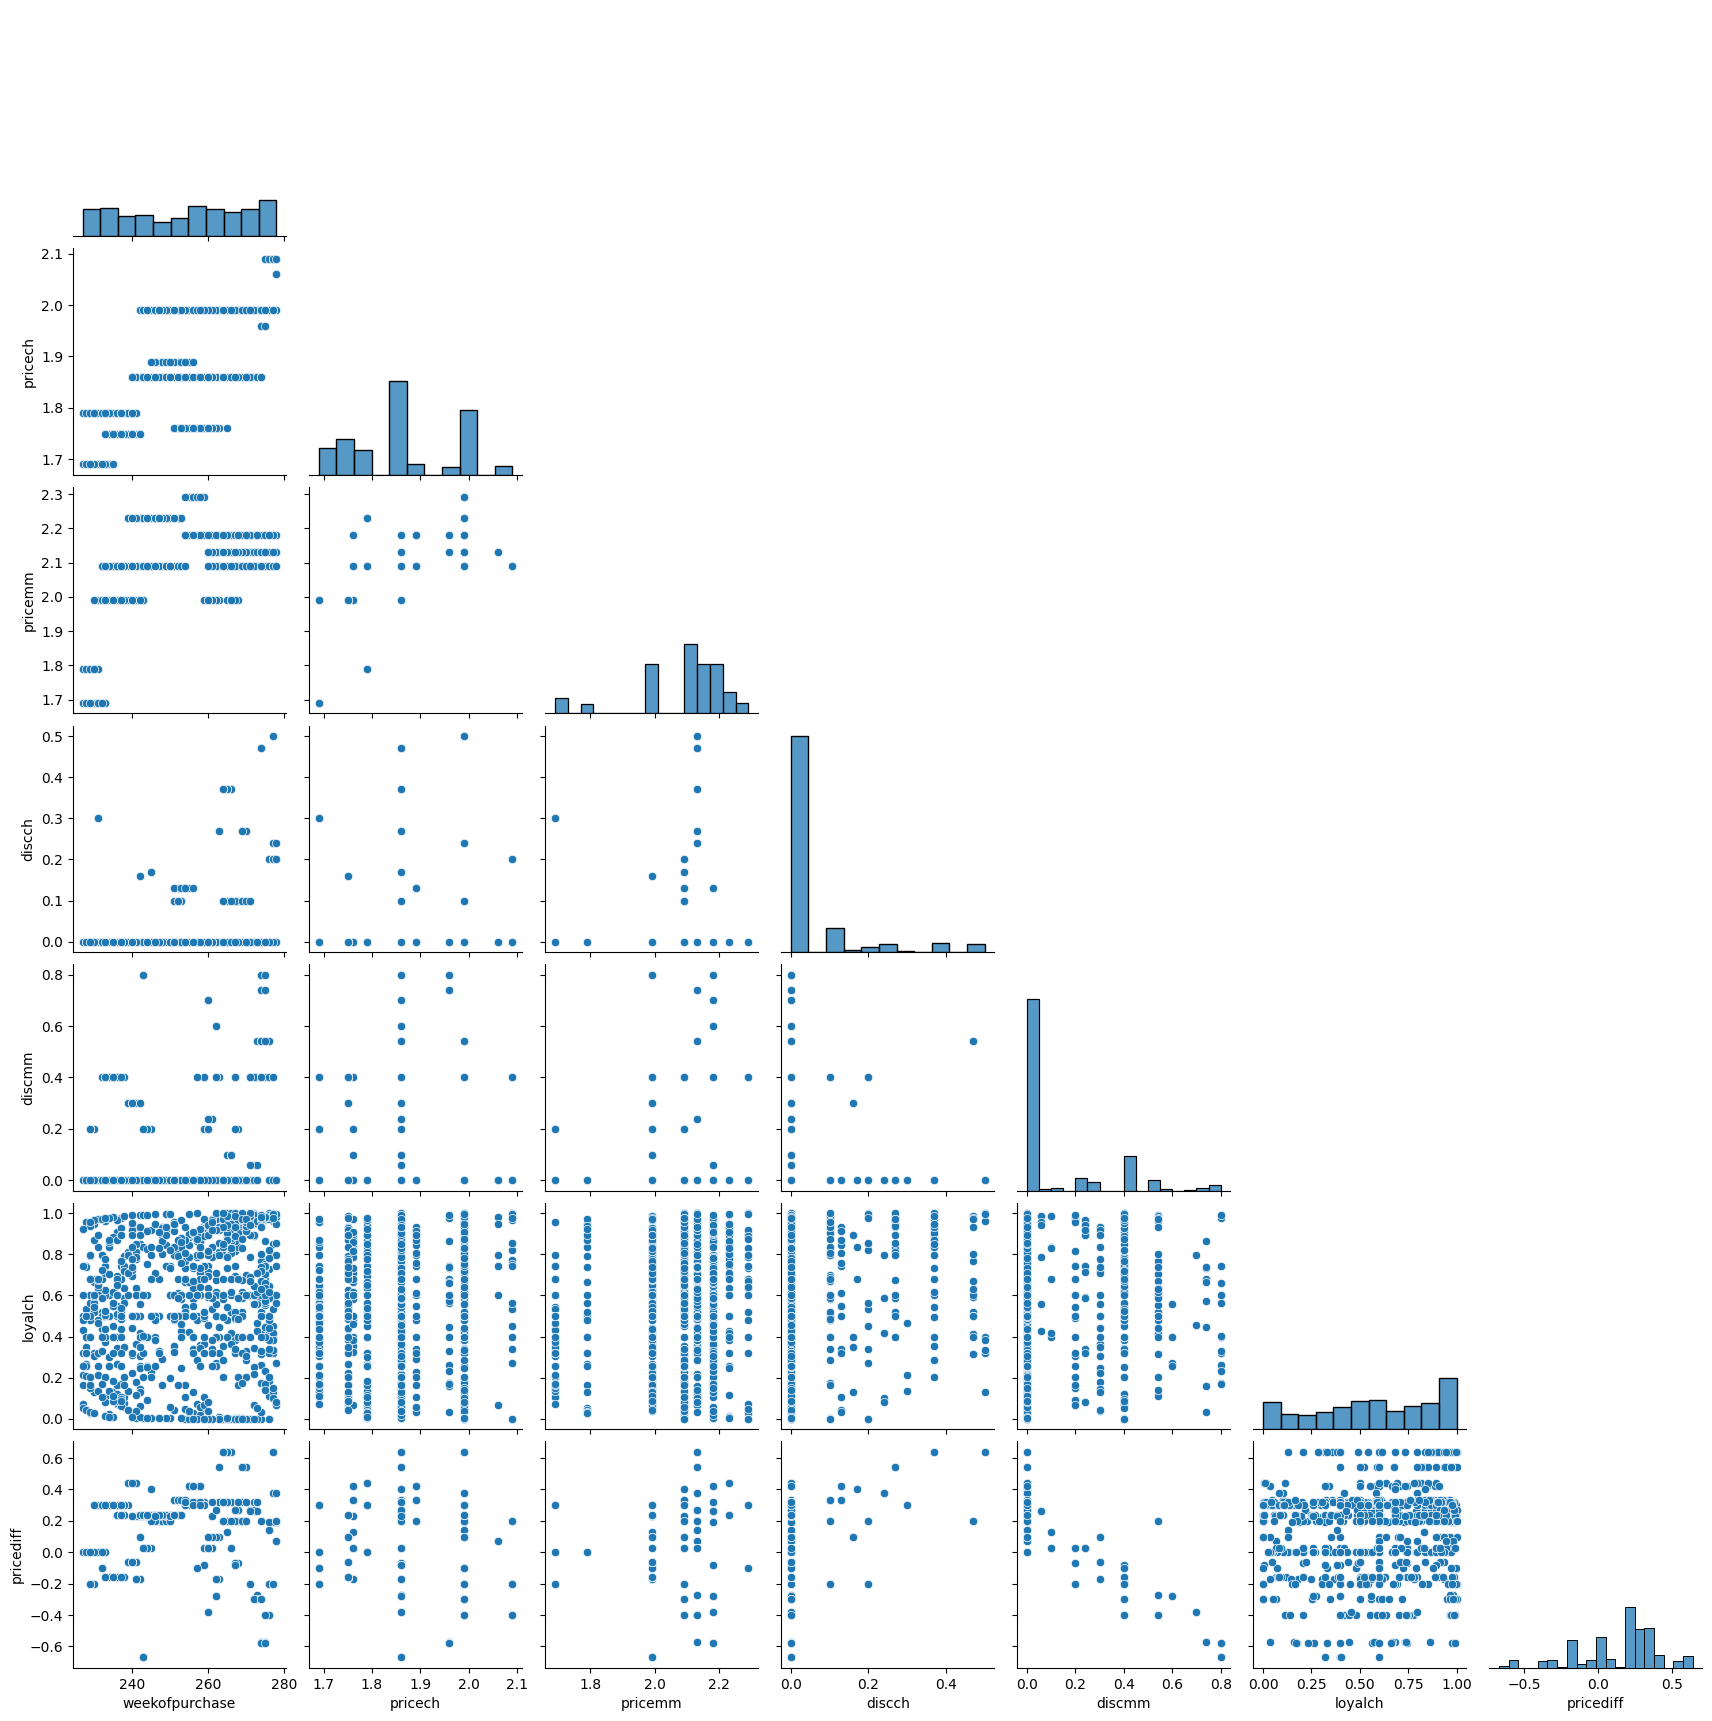

In [14]:
sns.pairplot(df_train, corner=True)
plt.show()

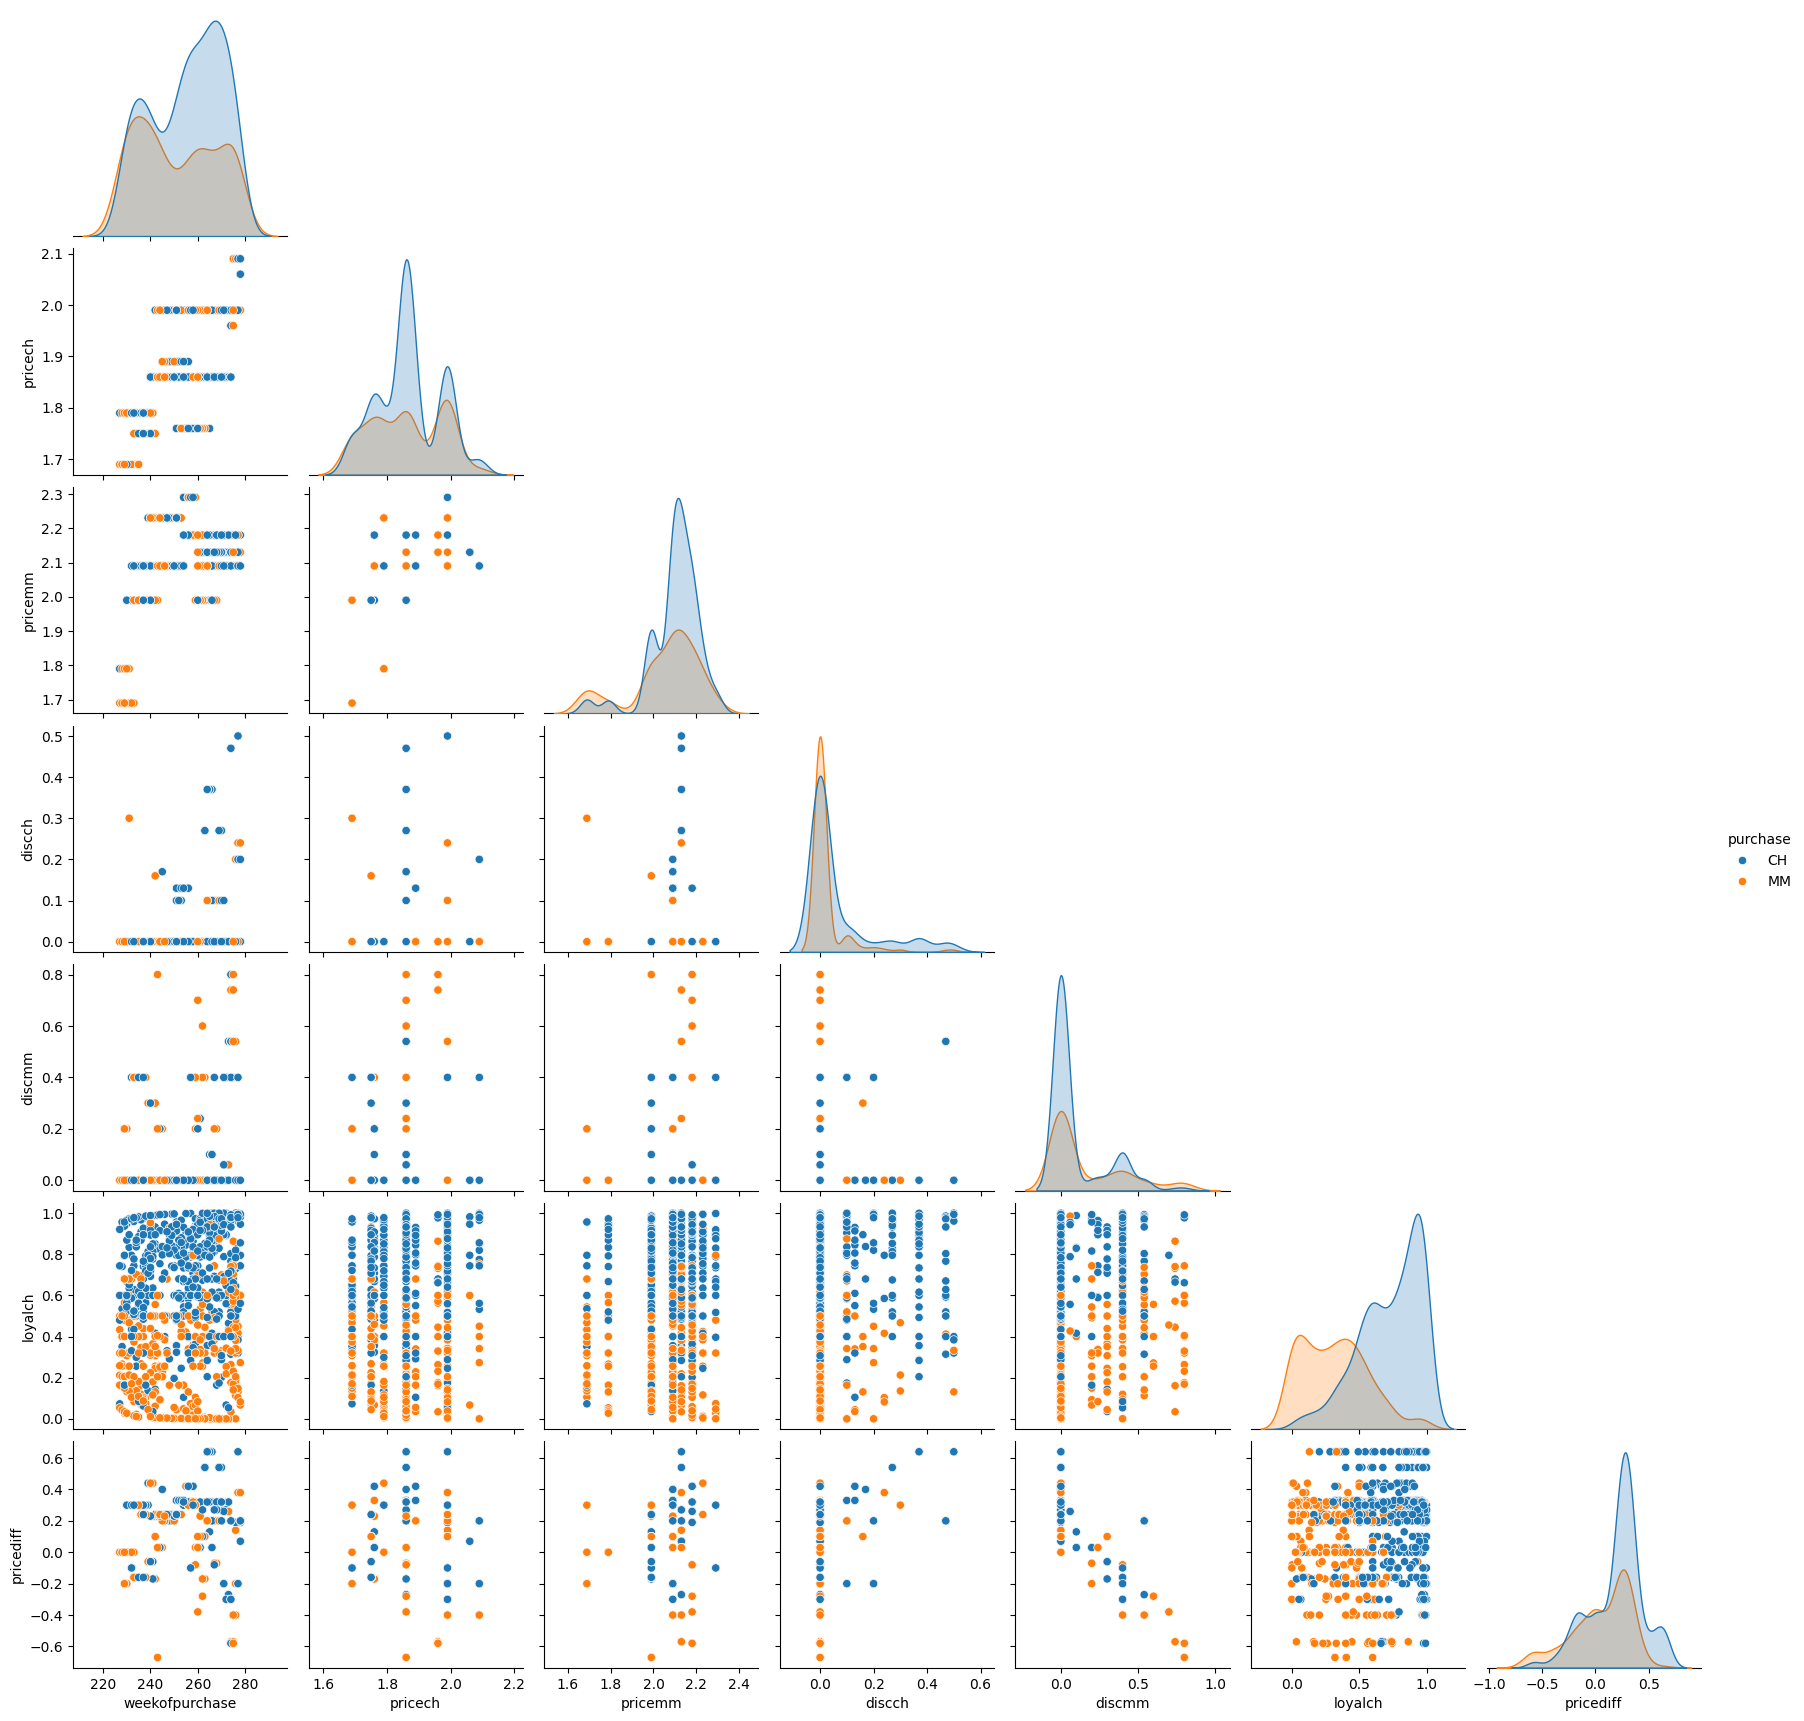

In [15]:
sns.pairplot(df_train, corner=True, hue='purchase')
plt.show()

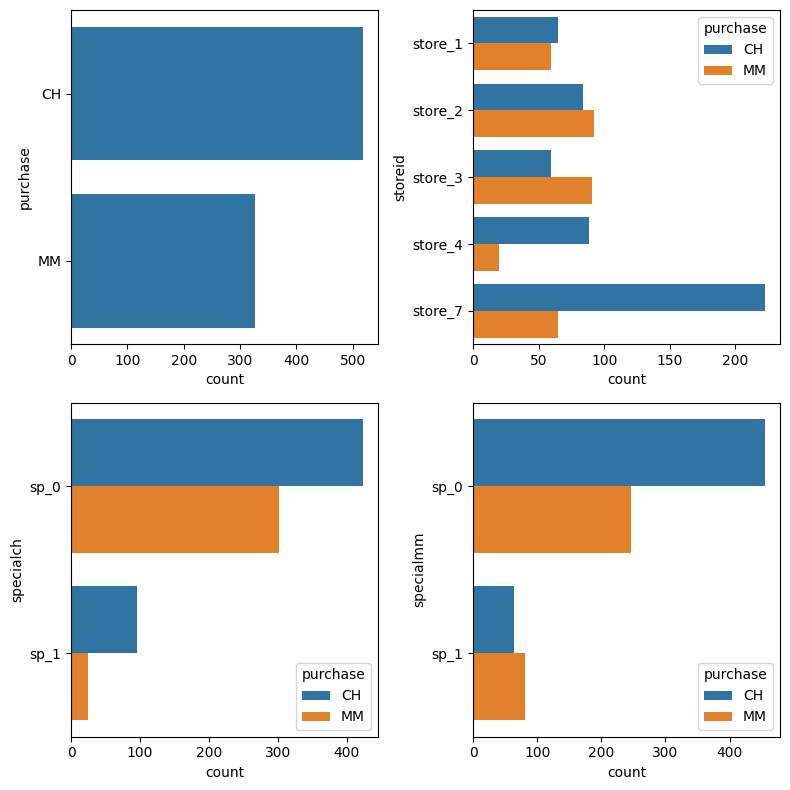

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
sns.countplot(df_train, y='purchase', ax=ax[0,0])
sns.countplot(df_train, y='storeid', ax=ax[0,1], hue='purchase')
sns.countplot(df_train, y='specialch', ax=ax[1,0], hue='purchase')
sns.countplot(df_train, y='specialmm', ax=ax[1,1], hue='purchase')
plt.tight_layout()
plt.show()

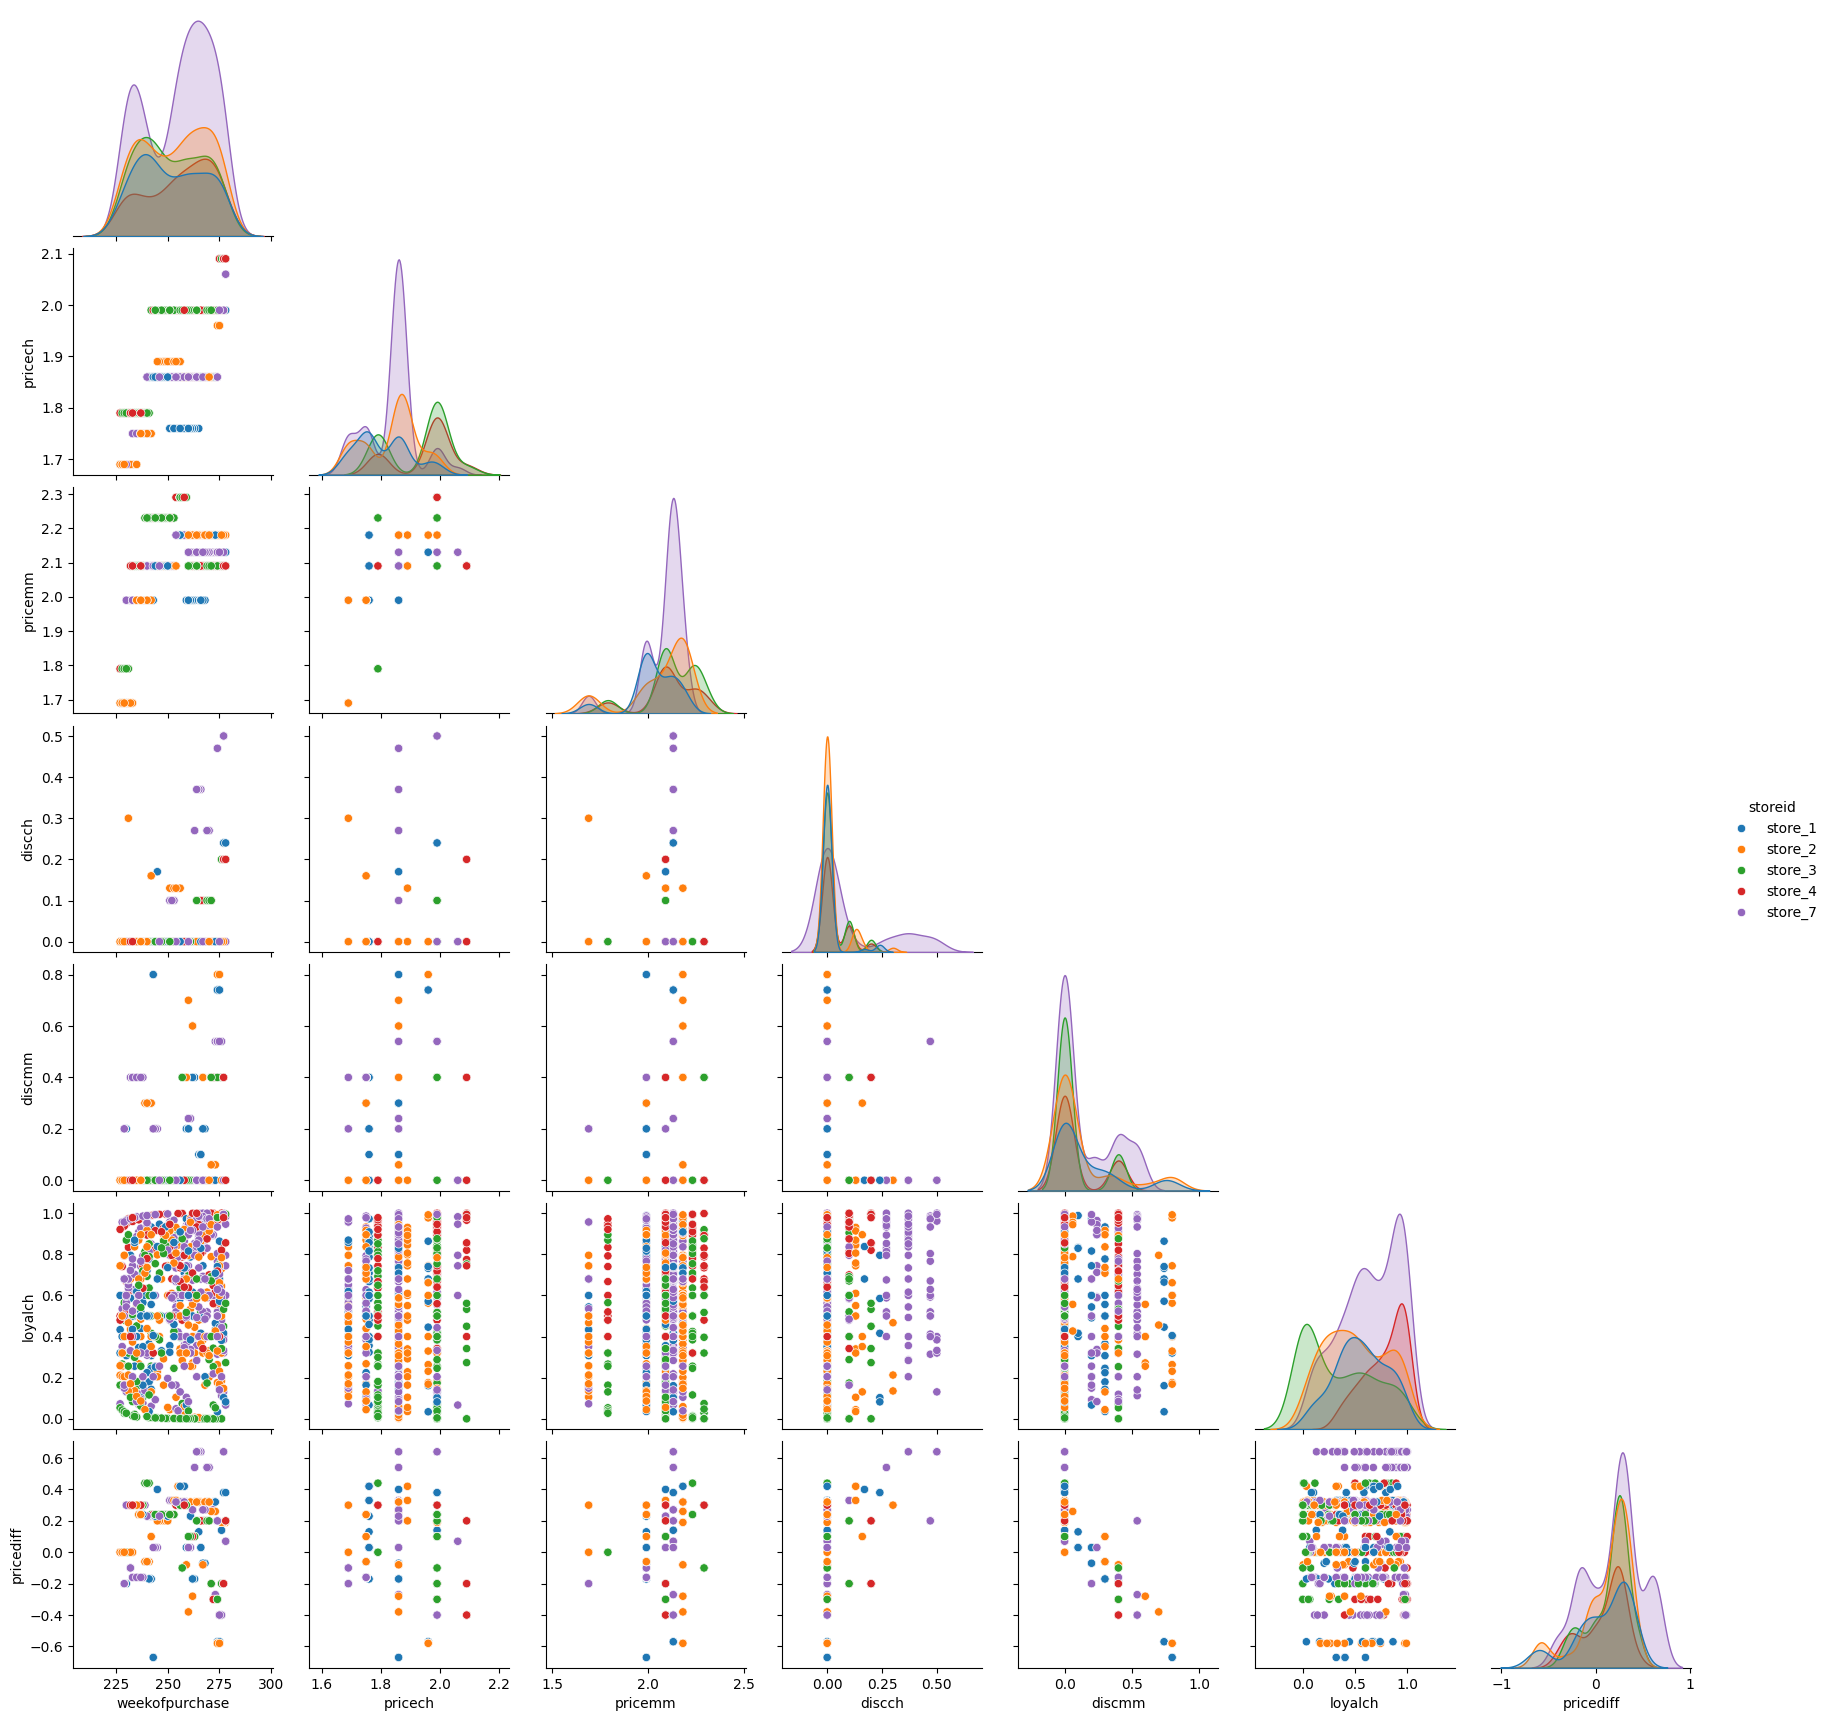

In [18]:
sns.pairplot(df_train, hue='storeid', corner=True)
plt.show()

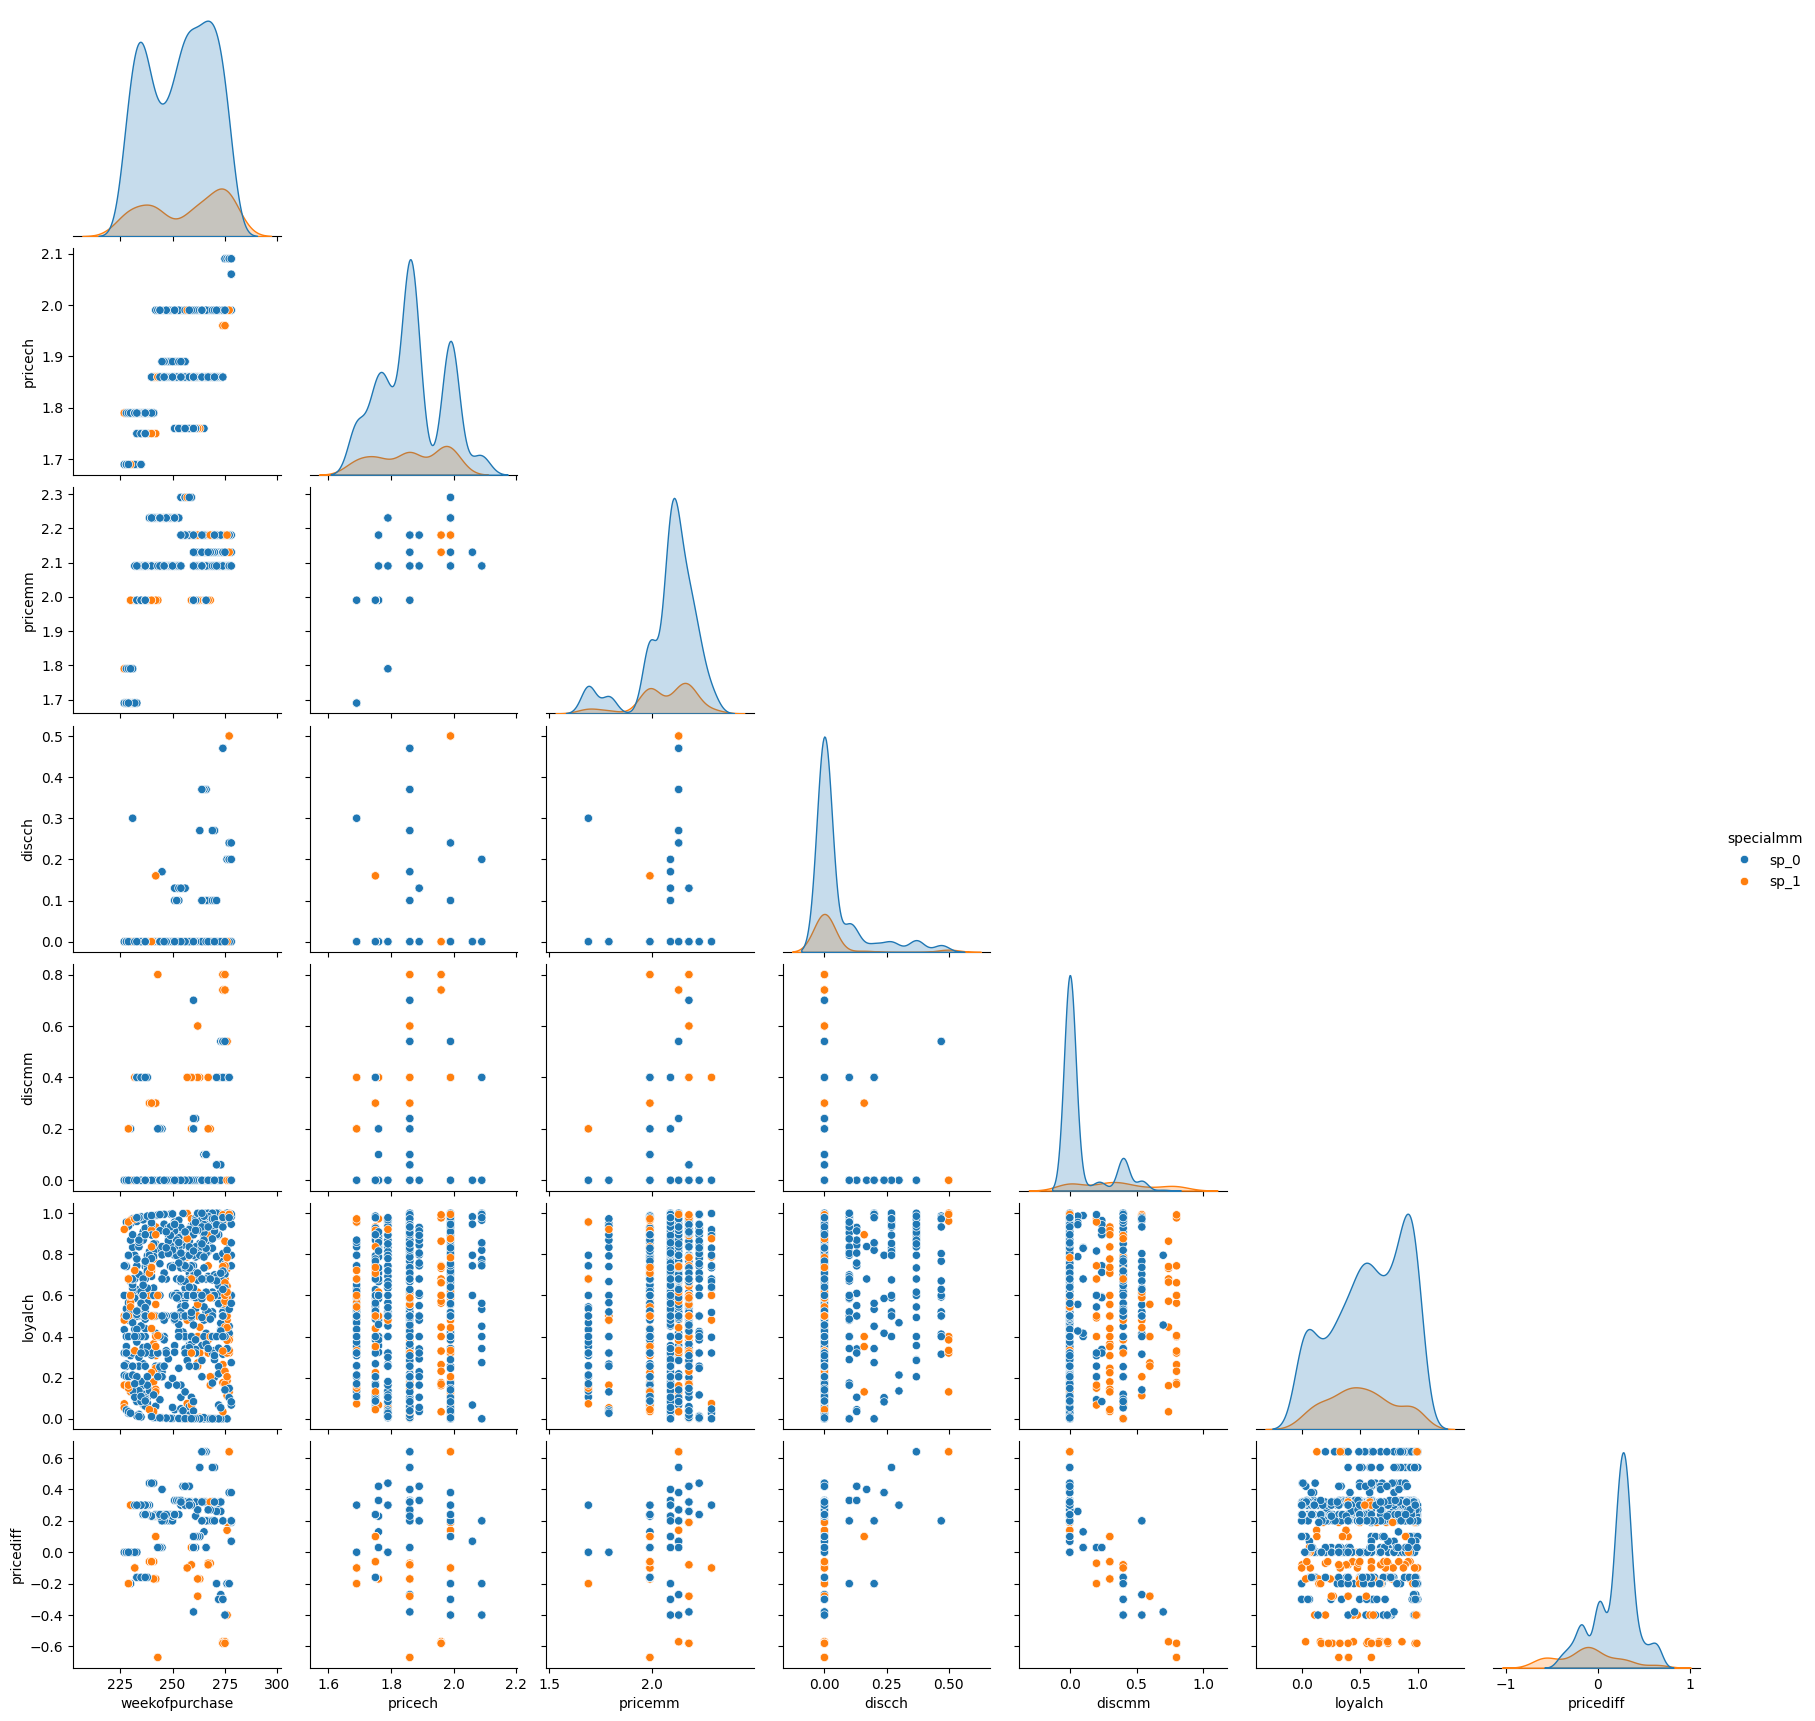

In [19]:
sns.pairplot(df_train, hue='specialmm', corner=True)
plt.show()

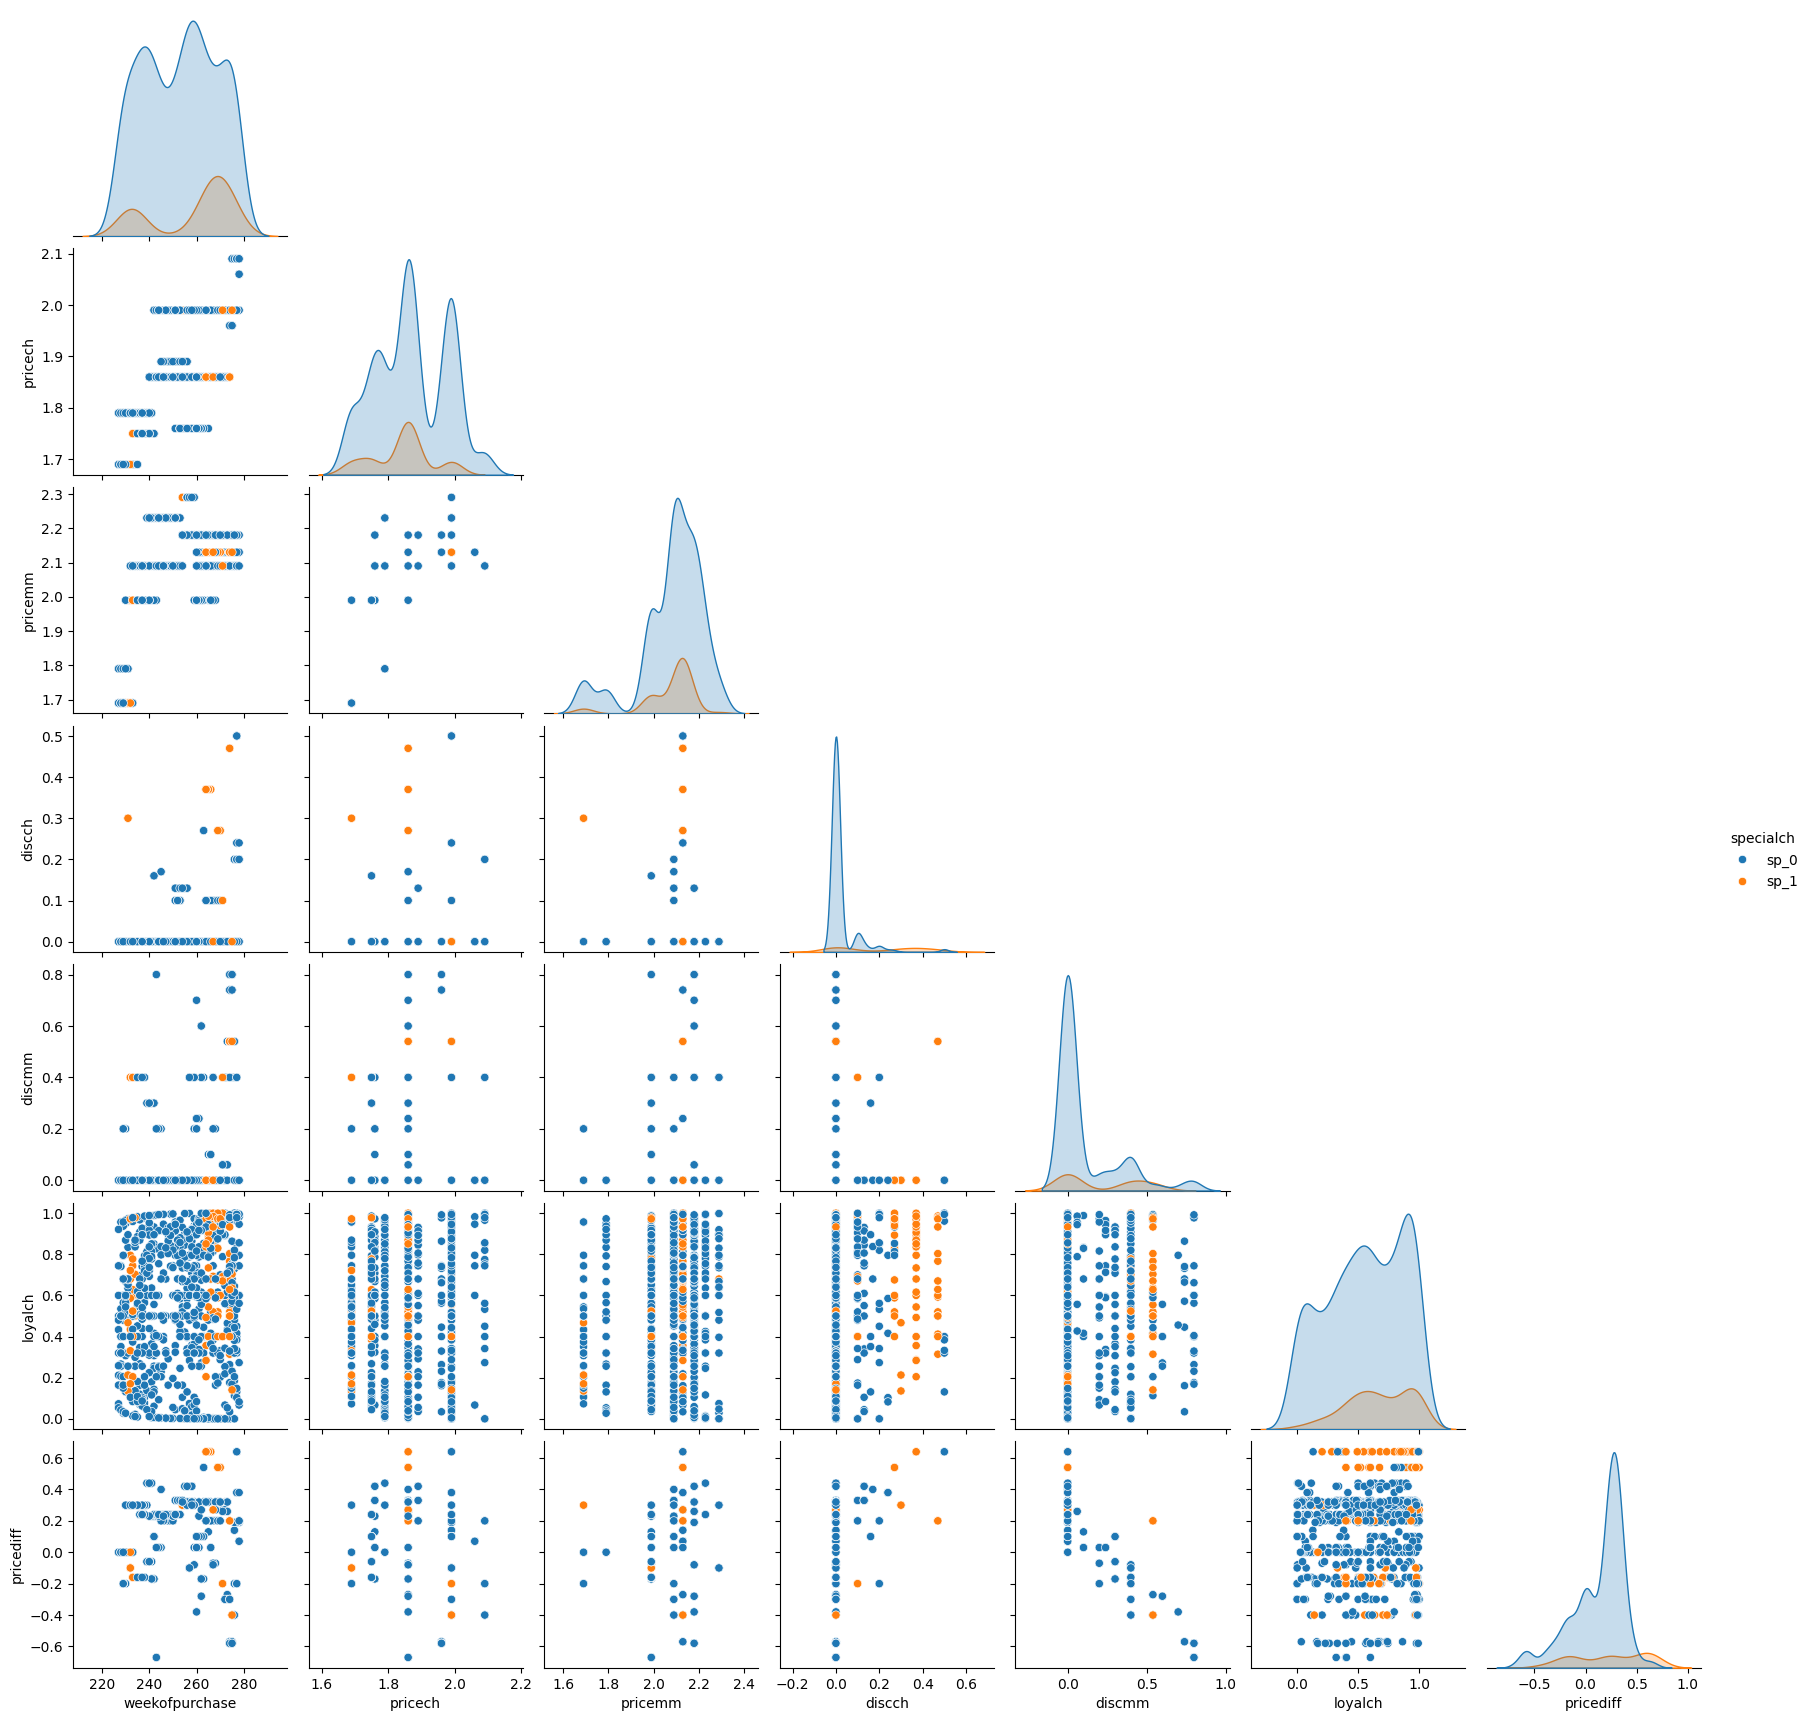

In [20]:
sns.pairplot(df_train, hue='specialch', corner=True)
plt.show()

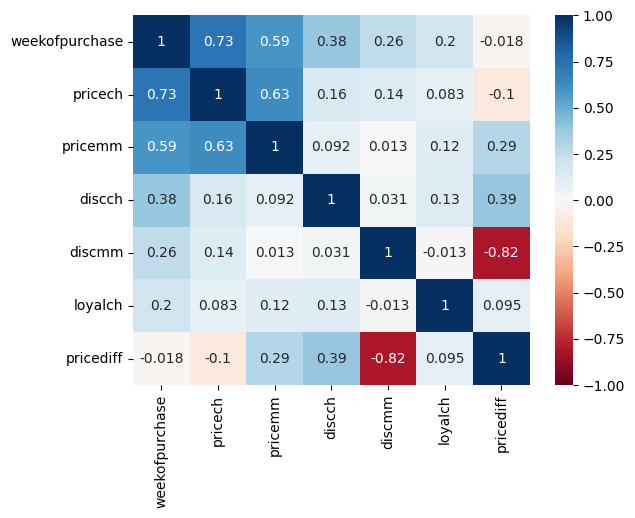

In [21]:
sns.heatmap(df_train.select_dtypes('number').corr(),vmin=-1, vmax=1 , cmap='RdBu', annot=True)
plt.show()

### 4. **Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [22]:
#Step 4 ML
X_train = df_train.drop(columns=['purchase'])
y_train = df_train['purchase']
X_val = df_val.drop(columns=['purchase'])
y_val = df_val['purchase']
X_test = df_test.drop(columns=['purchase'])
y_test = df_test['purchase']

In [23]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [28]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

num_proc = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
cat_proc = Pipeline(steps=[
    ('onehot',OneHotEncoder(drop='first'))
])
processor = ColumnTransformer(transformers=[
    ('num',num_proc,num_cols),
    ('cat',cat_proc,cat_cols)
])

In [46]:
clf_tree = Pipeline(steps=[
    ('proc', processor),
    ('tree', DecisionTreeClassifier(max_depth=6,
                                    random_state=2025,
                                    class_weight='balanced'))
])

clf_lr = Pipeline(steps=[
    ('proc', processor),
    ('lreg', LogisticRegression(class_weight='balanced',
                                   random_state=2025))
])

clf_rf = Pipeline(steps=[
    ('proc', processor),
    ('rf', RandomForestClassifier(class_weight='balanced',
                                  random_state=2025))
])

clf_hb = Pipeline(steps=[
    ('proc', processor),
    ('hb', HistGradientBoostingClassifier(class_weight='balanced',
                                          random_state=2025))
])

clf_nb = Pipeline(steps=[
    ('proc', processor),
    ('nb', GaussianNB())
])

In [37]:
clf_rf.fit(X_train, y_train_enc)
y_hat = clf_tree.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val_enc, y_hat):.2f}, F1 Score: {f1_score(y_val_enc, y_hat):.2f}, R2 Score: {r2_score(y_val_enc,y_hat):.2f}')

Accuracy: 0.75, F1 Score: 0.71, R2 Score: -0.06


In [42]:
models = [(clf_lr,'Logistic Regression','lreg__'), (clf_tree,'Decission Tree','tree__'),
          (clf_nb,'Naive Bayes','nb__'), (clf_rf,'Random forest','rf__'),
          (clf_hb,'Histogram Boosting','hb__')]
performance = {}
for est,name in models:
  est.fit(X_train, y_train_enc)
  y_hat = est.predict(X_val)
  acc = round(accuracy_score(y_val_enc, y_hat),2)
  f1 = round(f1_score(y_val_enc, y_hat),2)
  r2 = round(r2_score(y_val_enc,y_hat),2)
  performance[name] = {
      'accuracy':acc,
      'F1 Score':f1,
      'R2 Score':r2
  }


In [57]:
models = [(clf_lr,'Logistic Regression','lreg'), (clf_tree,'Decission Tree','tree'),
          (clf_nb,'Naive Bayes','nb'), (clf_rf,'Random forest','rf'),
          (clf_hb,'Histogram Boosting','hb')]

param_grids ={
    'lreg':{
        'lreg__C': [0.01, 0.1, 1],
    },
    'tree':{
        'tree__max_depth':[2,4,5,6,7],
        'tree__min_samples_split':[2,4,6],
    },
    'nb':{
        'nb__var_smoothing':[1e-9, 1e-8], #Proporcion de varianza que se descarta
    },
    'rf':{
        'rf__max_depth':[2,4,5,6,7],
        'rf__min_samples_split':[2,4,6],
        'rf__n_estimators':[50,100,150,200]
    },
    'hb':{
        'hb__max_depth':[2,4,5,6,7]
    }
}

performance = {}

for est, name, sname in models:
  est.fit(X_train, y_train_enc)
  estimator_cv = GridSearchCV(
      est,
      param_grid = param_grids[sname],
      cv = 5
  )

  estimator_cv.fit(X_train, y_train_enc)
  y_hat = estimator_cv.predict(X_val)
  acc = round(accuracy_score(y_val_enc, y_hat),2)
  f1 = round(f1_score(y_val_enc, y_hat),2)
  r2 = round(r2_score(y_val_enc,y_hat),2)
  params = estimator_cv.best_params_

  performance[name] = {
      'accuracy':acc,
      'F1 Score':f1,
      'R2 Score':r2,
      'Best Params':params,
      'estimator':estimator_cv.best_estimator_,

  }


In [58]:
df_models = pd.DataFrame(performance)
df_models.T

,accuracy,F1 Score,R2 Score,Best Params,estimator
Logistic Regression,0.81,0.78,0.2,{'lreg__C': 1},"(ColumnTransformer(transformers=[('num',\n ..."
Decission Tree,0.82,0.78,0.25,"{'tree__max_depth': 4, 'tree__min_samples_spli...","(ColumnTransformer(transformers=[('num',\n ..."
Naive Bayes,0.8,0.74,0.16,{'nb__var_smoothing': 1e-09},"(ColumnTransformer(transformers=[('num',\n ..."
Random forest,0.82,0.8,0.25,"{'rf__max_depth': 4, 'rf__min_samples_split': ...","(ColumnTransformer(transformers=[('num',\n ..."
Histogram Boosting,0.83,0.8,0.29,{'hb__max_depth': 2},"(ColumnTransformer(transformers=[('num',\n ..."
